# Scan aerosols and look at color dependence
=========================================================================


The purpose is to start to use PySynPhot software to calculate things on
SED, filter transmission,... For Calibration

- Sylvie Dagoret-Campagne
- Affiliation LAL-IN2P3-CNRS
- Work : LSST & StarDice
- date November 22 2017




- Read filters for LSST provided by KG May 30th 2017
- Generate LibRadTran atmosphere for any airmass - H2O - O3 combinations
- Generate the observed spectrum

In [ ]:
%load_ext autoreload
%autoreload 2

In [1]:
import numpy as np
# Set up matplotlib and use a nicer set of plot parameters
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import pandas as pd
import os
import re 

In [4]:
import astropy.units as u

In [5]:
from scipy.interpolate import interp1d

In [6]:
os.environ['PYSYN_CDBS']

'/Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs'

In [7]:
import sys
sys.path.append('../libradtransim')
sys.path.append('../LSSTFiltersKG')
sys.path.append('../lsstphotometry')

In [8]:
import libsimulateTranspLSSTScattAbsAer as atm
import libLSSTFiltersKG as lsst
import libLSSTPhotometry as photo

In [9]:
#help(atm)

In [10]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (6, 4),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [11]:
import pysynphot as S

# Defining LSST telescope

In [12]:
LSST_COLL_SURF=35*(u.m)**2/(u.cm)**2  # LSST collectif surface
WLMIN=3000.
WLMAX=11000.

In [13]:
NBINS=100000
BinWidth=(WLMAX-WLMIN)/float(NBINS)
wl=np.linspace(WLMIN,WLMAX,NBINS)

In [14]:
LSST_COLL_SURF.decompose()

<Quantity 350000.0>

In [15]:
S.refs.showref()

thermtable: /Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/mtab/tae17277m_tmt.fits
   waveset: Min: 500, Max: 26000, Num: 10000, Delta: None, Log: True
 comptable: /Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/mtab/16n1832tm_tmc.fits
graphtable: /Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/mtab/14l1632sm_tmg.fits
      area: 45238.93416


In [16]:
S.refs.setref(area=LSST_COLL_SURF.decompose(), waveset=None)

In [17]:
S.refs.set_default_waveset(minwave=3000, maxwave=11000, num=8000, delta=1, log=False)

In [18]:
S.refs.showref()

thermtable: /Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/mtab/tae17277m_tmt.fits
   waveset: Min: 3000, Max: 11000, Num: None, Delta: 1, Log: False
 comptable: /Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/mtab/16n1832tm_tmc.fits
graphtable: /Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/mtab/14l1632sm_tmg.fits
      area: 350000.0


## LSST effective filter


In [19]:
bp_u,bp_g,bp_r,bp_i,bp_z,bp_y4=lsst.GetAllLSSTBands('..')

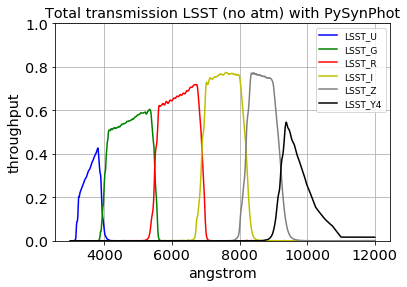

In [20]:
lsst.PlotAllLSSTBands(bp_u,bp_g,bp_r,bp_i,bp_z,bp_y4)

In [21]:
lsstbands=photo.LSSTTransmission('lssttel',6)
lsstbands.fill_passband(bp_u)
lsstbands.fill_passband(bp_g)
lsstbands.fill_passband(bp_r)
lsstbands.fill_passband(bp_i)
lsstbands.fill_passband(bp_z)
lsstbands.fill_passband(bp_y4)

one band added  1  /  6
one band added  2  /  6
one band added  3  /  6
one band added  4  /  6
one band added  5  /  6
one band added  6  /  6


## Read atmosphere

In [22]:
tau_aerosol=np.linspace(0.,0.5,10)
lambda0_aerosol=500. # nm
airmass=1.
pwv=4.0     # mm
ozone=300. # DU

In [23]:
photo_atm=photo.Atmosphere('libradtran')

In [24]:
all_wl_atm= []
all_tr_atm= []
index=0
for tau in tau_aerosol:
      path,thefile=atm.ProcessSimulationaer(airmass,pwv,ozone,lambda0_aerosol,tau) 
      fullfilename=os.path.join(path,thefile)
      atm_data=np.loadtxt(fullfilename)
      wl_atm=atm_data[:,0]
      tr_atm=atm_data[:,1]  
      all_wl_atm.append(wl_atm) 
      all_tr_atm.append(tr_atm) 
      if index==0:
        photo_atm.fill_array(wl_atm)
        
      photo_atm.fill_array(tr_atm)
        
        
      index+=1

--------------------------------------------
 1) airmass =  1.0
 2) pwv =  4.0
 3) oz =  300.0
 4) wl0 =  500.0
 5) tau0 =  0.0
--------------------------------------------
('Running uvspec with input file: ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z10_wv40_oz30_aer0.INP')
('Output to file                : ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z10_wv40_oz30_aer0.OUT')
('uvspec cmd: ', '/Users/dagoret/MacOSX/External/libRadtran/libRadtran-2.0.1/bin/uvspec  < simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z10_wv40_oz30_aer0.INP > simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z10_wv40_oz30_aer0.OUT')
--------------------------------------------
 1) airmass =  1.0
 2) pwv =  4.0
 3) oz =  300.0
 4) wl0 =  500.0
 5) tau0 =  0.0555555555556
--------------------------------------------
('Running uvspec with input file: ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z10_wv40_oz30_aer5.INP')
('Output to file         

In [25]:
theatmosph=photo_atm.get_array()

In [26]:
pd.DataFrame(theatmosph)

,0,1,2,3,4,5,6,7,8,9,...,941,942,943,944,945,946,947,948,949,950
0,250.0,251.0,252.0,253.0,254.0,255.0,256.0,257.0,258.0,259.0,...,1191.000000,1192.000000,1193.000000,1194.000000,1195.000000,1196.000000,1197.000000,1198.000000,1199.000000,1200.000000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.963772,0.985182,0.985182,0.970041,0.970041,0.977899,0.977899,0.963689,0.963689,0.960683
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.948341,0.969432,0.969432,0.954581,0.954581,0.962343,0.962343,0.948413,0.948413,0.945492
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.933157,0.953933,0.953933,0.939367,0.939367,0.947035,0.947035,0.933379,0.933379,0.930541
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.918216,0.938682,0.938682,0.924395,0.924395,0.931970,0.931970,0.918583,0.918583,0.915826
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.903514,0.923675,0.923675,0.909663,0.909663,0.917145,0.917145,0.904022,0.904022,0.901345
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.889048,0.908908,0.908908,0.895165,0.895165,0.902556,0.902556,0.889691,0.889691,0.887092
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.874813,0.894377,0.894377,0.880898,0.880898,0.888199,0.888199,0.875588,0.875588,0.873064
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.860807,0.880078,0.880078,0.866858,0.866858,0.874070,0.874070,0.861709,0.861709,0.859259
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.847024,0.866008,0.866008,0.853043,0.853043,0.860166,0.860166,0.848049,0.848049,0.845671


### bind together wavelength and transmission

In [27]:
wl_and_tr_atm=zip(all_wl_atm,all_tr_atm)  

## plot air-transmission

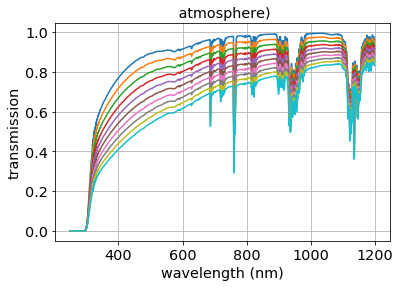

In [28]:
for wl_atm,tr_atm in wl_and_tr_atm:
    plt.plot(wl_atm,tr_atm)
plt.grid()
plt.title(" atmosphere)")
plt.xlabel("wavelength (nm)")
plt.ylabel("transmission")
plt.savefig("atm-transm.png")

# LSST transmission

In [29]:
bp_atm= S.ArrayBandpass(wl_atm*10.,tr_atm, name='LSST_ATM')

In [30]:
all_bp_u_atm = []
all_bp_g_atm = []
all_bp_r_atm = []
all_bp_i_atm = []
all_bp_z_atm = []
all_bp_y4_atm = []
index=0
for wl_atm,tr_atm in wl_and_tr_atm:
    atmname='ATM_'+str(index)
    bp_atm= S.ArrayBandpass(wl_atm*10.,tr_atm, name=atmname)

    bp_u_atm = bp_u*bp_atm
    bp_g_atm = bp_g*bp_atm
    bp_r_atm = bp_r*bp_atm
    bp_i_atm = bp_i*bp_atm
    bp_z_atm = bp_z*bp_atm
    bp_y4_atm = bp_y4*bp_atm
    
    bp_u_atm.binning=1.
    bp_g_atm.binning=1.
    bp_r_atm.binning=1.
    bp_i_atm.binning=1.
    bp_z_atm.binning=1.
    bp_y4_atm.binning=1.
    
    all_bp_u_atm.append(bp_u_atm)
    all_bp_g_atm.append(bp_g_atm) 
    all_bp_r_atm.append(bp_r_atm) 
    all_bp_i_atm.append(bp_i_atm) 
    all_bp_z_atm.append(bp_z_atm) 
    all_bp_y4_atm.append(bp_y4_atm)     
    index+=1

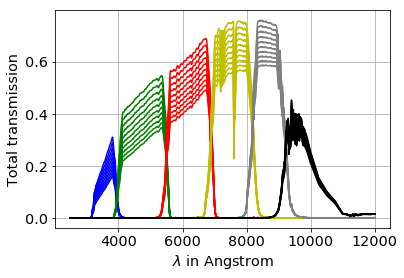

In [31]:
for bp_u_atm in all_bp_u_atm:
    plt.plot(bp_u_atm.wave, bp_u_atm.throughput, 'b')
for bp_g_atm in all_bp_g_atm:
    plt.plot(bp_g_atm.wave, bp_g_atm.throughput, 'g')
for bp_r_atm in all_bp_r_atm:
    plt.plot(bp_r_atm.wave, bp_r_atm.throughput, 'r')
for bp_i_atm in all_bp_i_atm:
    plt.plot(bp_i_atm.wave, bp_i_atm.throughput, 'y')
for bp_z_atm in all_bp_z_atm:
    plt.plot(bp_z_atm.wave, bp_z_atm.throughput, color='grey')
for bp_y4_atm in all_bp_y4_atm:
    plt.plot(bp_y4_atm.wave, bp_y4_atm.throughput, 'k')
plt.xlabel( '$\lambda$ in Angstrom')
plt.ylabel('Total transmission')
plt.grid()

# Observation

## Defines the SED

In [32]:
filename = os.path.join(os.environ['PYSYN_CDBS'], 'calspec', 'hd111980_stis_003.fits')
sed = S.FileSpectrum(filename)
sed.flux

array([  2.16790002e-14,   2.66180002e-14,   2.03460007e-14, ...,
         9.32662788e-19,   9.23448099e-19,   9.14324504e-19])

In [33]:
bp_sed=S.ArrayBandpass(sed.wave,sed.flux, name='SED')

Text(0.5,1,u'hd111980_stis_003.fits')

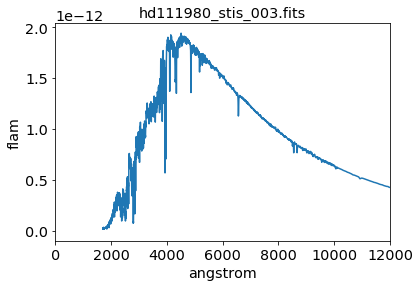

In [34]:
plt.plot(sed.wave,sed.flux)
plt.xlim(0.,12000)
plt.xlabel(sed.waveunits)
plt.ylabel(sed.fluxunits)
plt.title(os.path.basename(sed.name))

- flam unit is erg per sec per cm2 per angstrom

## Defines all the  observation

In [35]:
all_obs_u = []
all_obs_g = []
all_obs_r = []
all_obs_i = []
all_obs_z = []
all_obs_y4 = []


index=0
for bp_u_atm in all_bp_u_atm:
    obs_u = S.Observation(sed,bp_u_atm)
    obs_u.primary_area=LSST_COLL_SURF.decompose()
    all_obs_u.append(obs_u)
    index+=1
    
index=0
for bp_g_atm in all_bp_g_atm:
    obs_g = S.Observation(sed,bp_g_atm)
    obs_g.primary_area=LSST_COLL_SURF.decompose()
    all_obs_g.append(obs_g)
    index+=1
    
    
index=0
for bp_r_atm in all_bp_r_atm:
    obs_r = S.Observation(sed,bp_r_atm)
    obs_r.primary_area=LSST_COLL_SURF.decompose()
    all_obs_r.append(obs_r)
    index+=1
    
index=0
for bp_i_atm in all_bp_i_atm:
    obs_i = S.Observation(sed,bp_i_atm)
    obs_i.primary_area=LSST_COLL_SURF.decompose()
    all_obs_i.append(obs_i)
    index+=1    
    
index=0
for bp_z_atm in all_bp_z_atm:
    obs_z = S.Observation(sed,bp_z_atm)
    obs_z.primary_area=LSST_COLL_SURF.decompose()
    all_obs_z.append(obs_z)
    index+=1    
    
index=0
for bp_y4_atm in all_bp_y4_atm:
    obs_y4 = S.Observation(sed,bp_y4_atm)    
    obs_y4.primary_area=LSST_COLL_SURF.decompose()
    all_obs_y4.append(obs_y4)
    index+=1    
    
    

((LSST_U * ATM_0)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((LSST_U * ATM_1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((LSST_U * ATM_2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((LSST_U * ATM_3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((LSST_U * ATM_4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((LSST_U * ATM_5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((LSST_U * ATM_6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((LSST_U * ATM_7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((LSST_U * ATM_8)) does 

## Plot the observation

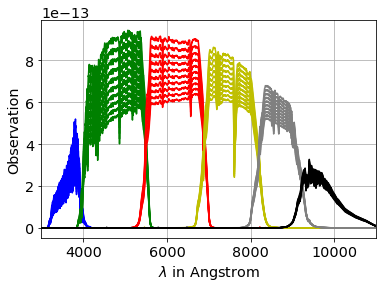

In [36]:
for obs_u in all_obs_u:
    plt.plot(obs_u.wave,obs_u.flux,'b')
    
for obs_g in all_obs_g:
    plt.plot(obs_g.wave,obs_g.flux,'g')
    
for obs_r in all_obs_r:
    plt.plot(obs_r.wave,obs_r.flux,'r')
    
for obs_i in all_obs_i:
    plt.plot(obs_i.wave,obs_i.flux,'y')
    
for obs_z in all_obs_z:
    plt.plot(obs_z.wave,obs_z.flux,color='grey')
    
for obs_y4 in all_obs_y4:
    plt.plot(obs_y4.wave,obs_y4.flux,color='black')
    
plt.xlim(WLMIN,WLMAX) 
plt.xlabel( '$\lambda$ in Angstrom')
plt.ylabel('Observation')
plt.grid()

### Magnitude

In [37]:
all_interp_u = []
all_interp_g = []
all_interp_r = []
all_interp_i = []
all_interp_z = []
all_interp_y4 = []

for obs_u in all_obs_u:
    f_u=interp1d(obs_u.wave,obs_u.flux,kind='cubic')
    all_interp_u.append(f_u)

for obs_g in all_obs_g:
    f_g=interp1d(obs_g.wave,obs_g.flux,kind='cubic')
    all_interp_g.append(f_g)

for obs_r in all_obs_r:
    f_r=interp1d(obs_r.wave,obs_r.flux,kind='cubic')
    all_interp_r.append(f_r)
    
for obs_i in all_obs_i:
    f_i=interp1d(obs_i.wave,obs_i.flux,kind='cubic')
    all_interp_i.append(f_i)
    
for obs_z in all_obs_z:
    f_z=interp1d(obs_z.wave,obs_z.flux,kind='cubic')
    all_interp_z.append(f_z)
    
for obs_y4 in all_obs_y4:
    f_y4=interp1d(obs_y4.wave,obs_y4.flux,kind='cubic')
    all_interp_y4.append(f_y4)
    

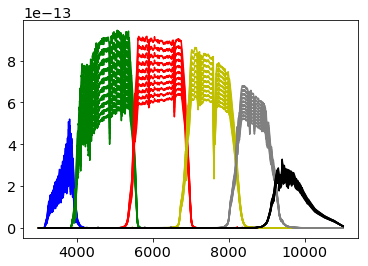

In [38]:
for interp_u in all_interp_u:
    plt.plot(wl,interp_u(wl),'b-')
for interp_g in all_interp_g:
    plt.plot(wl,interp_g(wl),'g-')
for interp_r in all_interp_r:
    plt.plot(wl,interp_r(wl),'r-')
for interp_i in all_interp_i:
    plt.plot(wl,interp_i(wl),'y-')
for interp_z in all_interp_z:
    plt.plot(wl,interp_z(wl),color='grey')
for interp_y4 in all_interp_y4:
    plt.plot(wl,interp_y4(wl),color='black')

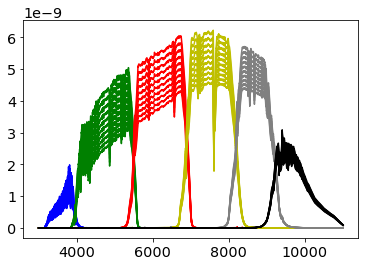

In [39]:
for interp_u in all_interp_u:
    plt.plot(wl,interp_u(wl)*wl,'b-')
for interp_g in all_interp_g:
    plt.plot(wl,interp_g(wl)*wl,'g-')
for interp_r in all_interp_r:
    plt.plot(wl,interp_r(wl)*wl,'r-')
for interp_i in all_interp_i:
    plt.plot(wl,interp_i(wl)*wl,'y-')
for interp_z in all_interp_z:
    plt.plot(wl,interp_z(wl)*wl,color='grey')
for interp_y4 in all_interp_y4:
    plt.plot(wl,interp_y4(wl)*wl,color='black')


In [40]:
def CountRate(wl,fl):
    dlambda=BinWidth 
    df=wl*fl*LSST_COLL_SURF/(S.units.C*S.units.H)*dlambda
    # (erg/s/cm2/Angstrom) x (Angstrom)  x  (cm^2) / (erg . s . Angstrom /s) * Angstrom
    # units :  s-1
    count=df.sum()
    return count

In [41]:
def InstrumMag(wl,fl):
    m=-2.5*np.log10(CountRate(wl,fl))
    return m

In [42]:
def ComputeColor(wl,fl1,fl2):
    m1=InstrumMag(wl,fl1)
    m2=InstrumMag(wl,fl2)
    return m1-m2

# G-R
---------

In [43]:
fluxes_ziped=zip(all_interp_g,all_interp_r)
all_color_gr=[]
for interp_1,interp_2 in fluxes_ziped:
    color=ComputeColor(wl,interp_1(wl),interp_2(wl))
    all_color_gr.append(color)
    
all_color_gr=np.array(all_color_gr)

Text(0.5,1,u'G-R versus aerosol optical depth')

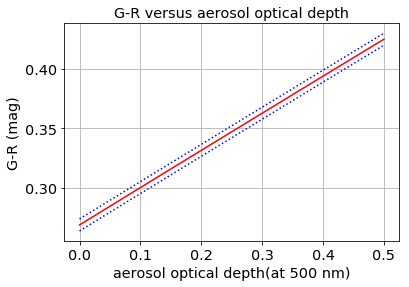

In [44]:
plt.plot(tau_aerosol,all_color_gr,'r-')
plt.plot(tau_aerosol,all_color_gr-0.005,'b:')
plt.plot(tau_aerosol,all_color_gr+0.005,'b:')
plt.grid()
plt.xlabel('aerosol optical depth(at 500 nm)')
plt.ylabel('G-R (mag)')
plt.title('G-R versus aerosol optical depth')

In [45]:
#mag_gr_to_tau=interp1d(all_color_gr,tau_aerosol)
mag_gr_to_tau= np.poly1d(np.polyfit(all_color_gr,tau_aerosol, 2))

#mag_gr_to_tau_up=interp1d(all_color_gr-0.05,tau_aerosol)
mag_gr_to_tau_up= np.poly1d(np.polyfit(all_color_gr-0.05,tau_aerosol, 2))

#mag_gr_to_tau_do=interp1d(all_color_gr+0.05,tau_aerosol)
mag_gr_to_tau_do= np.poly1d(np.polyfit(all_color_gr+0.05,tau_aerosol, 2))


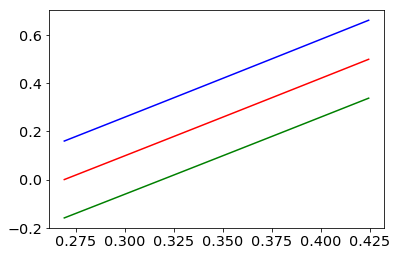

In [46]:
plt.plot(all_color_gr,mag_gr_to_tau(all_color_gr),'r')
plt.plot(all_color_gr,mag_gr_to_tau_up(all_color_gr),'b')
plt.plot(all_color_gr,mag_gr_to_tau_do(all_color_gr),'g')

In [47]:
error_tauaerosols=(mag_gr_to_tau_up(all_color_gr)-mag_gr_to_tau_do(all_color_gr))/2./mag_gr_to_tau(all_color_gr)

Text(0,0.5,u'accuracy on aerosols')

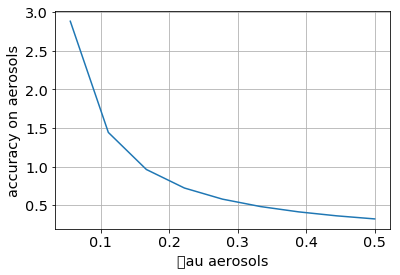

In [48]:
plt.plot(tau_aerosol[1:],error_tauaerosols[1:])
plt.ylim=(0,10.)
plt.grid(True)
plt.xlabel('\tau aerosols')
plt.ylabel('accuracy on aerosols')